<a href="https://colab.research.google.com/github/yongtaoliu/Physics--cVAE/blob/main/Notebook3_2DCards_Physics_%3EVAE_iVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

October 17, 2021

- Initial cVAE notebooks by Maxim Ziatdinov
- Integration by Yongtao Liu
- Modification by Sergei V. Kalinin

In [ ]:
# !pip install git+https://github.com/ziatdinovmax/pyroved
!pip install pyroved

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceledERROR: Operation cancelled by user


In [ ]:
!pip install -q pyroved kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 37.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.


Imports:

In [ ]:
import pyroved as pv
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch.nn as nn
import kornia as K
tt = torch.tensor

In [ ]:
!gdown https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip cards.zip

Downloading...
From: https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
To: /content/cards.zip
100% 30.2k/30.2k [00:00<00:00, 63.3MB/s]
Archive:  cards.zip
   creating: cards/
  inflating: cards/card4.JPG         
  inflating: cards/card1.JPG         
  inflating: cards/card2.JPG         
  inflating: cards/card3.JPG         


Load data into the notebook and transform to a proper format:

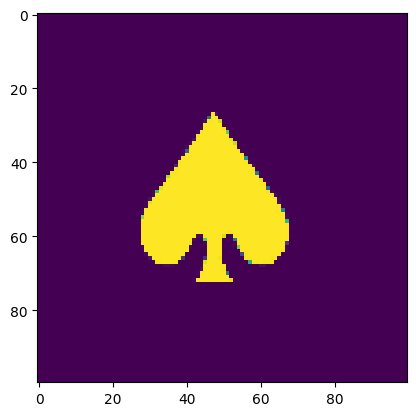

In [ ]:
# You can easily load the same file here in all 4 card groups
# E.g. use cards3 for hearts

rs = lambda x: cv2.resize(x, (100, 100), cv2.INTER_CUBIC)
card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
card1 = tt(1 - card1 / card1.max())
card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
card2 = tt(1 - card2 / card2.max())
card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
card3 = tt(1 - card3 / card3.max())
card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
card4 = tt(1 - card4 / card4.max())
plt.imshow(card2)

(-0.5, 99.5, 99.5, -0.5)

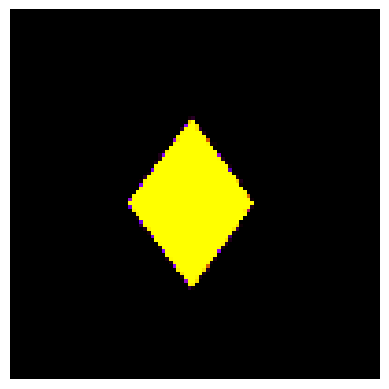

In [ ]:
plt.imshow(card4, cmap='gnuplot')
plt.axis('off')

In [ ]:
def affine_transform(imgdata: torch.Tensor,
                     angle: torch.Tensor = None,
                     shift: torch.Tensor = None,
                     shear: torch.Tensor = None) -> torch.Tensor:                
    imgdata = imgdata[:,:,10:90, 10:90]
    if angle is not None:
        imgdata = K.geometry.rotate(imgdata, angle)
    if shear is not None:
        imgdata = K.geometry.shear(imgdata, shear)
    if shift is not None:
        imgdata = K.geometry.translate(imgdata, shift)
    return imgdata

batch_size = 1000

cards1 = card1[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards1 = cards1.to(torch.float32)
theta1 = torch.distributions.Uniform(0, 30).sample((batch_size,))
shift1 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear1 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards1_transformed = affine_transform(cards1, theta1, shift1, shear1)

cards2 = card2[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards2 = cards2.to(torch.float32)
theta2 = torch.distributions.Uniform(0, 30).sample((batch_size,))
shift2 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear2 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards2_transformed = affine_transform(cards2, theta2, shift2, shear2)

cards3 = card3[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards3 = cards3.to(torch.float32)
theta3 = torch.distributions.Uniform(0, 30).sample((batch_size,))
shift3 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear3 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards3_transformed = affine_transform(cards3, theta3, shift3, shear3)

cards4 = card4[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards4 = cards4.to(torch.float32)
theta4 = torch.distributions.Uniform(0, 30).sample((batch_size,))
shift4 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear4 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards4_transformed = affine_transform(cards4, theta4, shift4, shear4)

# Concatenate (this is our training set)
cards_all = torch.cat([cards1_transformed, cards2_transformed, cards3_transformed, cards4_transformed]).squeeze().float()
theta_all = torch.cat([theta1, theta2, theta3, theta4]).squeeze().float()
shift_all = torch.cat([shift1, shift2, shift3, shift4]).squeeze().float()
shear_all = torch.cat([shear1, shear2, shear3, shear4]).squeeze().float()

index_array = np.concatenate([np.zeros(cards1.shape[0]), 
                              np.zeros(cards2.shape[0])+1, 
                              np.zeros(cards3.shape[0])+2, 
                              np.zeros(cards4.shape[0])+3]
                             )

cards_all = cards_all + 0.01 * torch.randn(size=(4000,80,80))

torch.Size([4000, 80, 80])


tensor([29.1254, 13.8248, 13.1469,  ..., 24.8981, 25.5174,  8.8632])

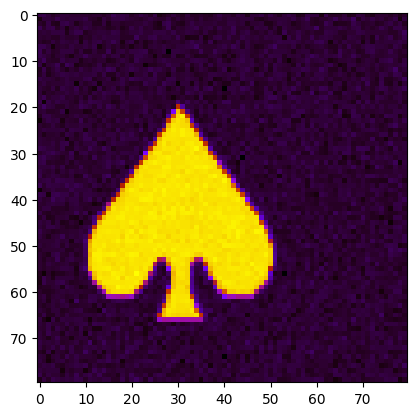

In [ ]:
print(cards_all.shape)
plt.imshow(cards_all[1000], cmap='gnuplot')
theta_all

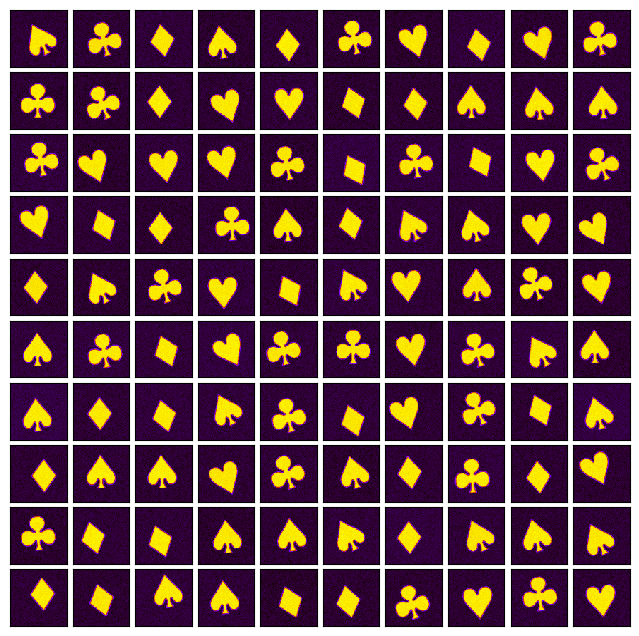

In [ ]:
np.random.seed(1)
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all))
    ax.imshow(cards_all[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
train_data = cards_all 
translation_x_, translation_y_ = shift_all[:,0].unsqueeze(1), shift_all[:,1].unsqueeze(1)
rotate_ = theta_all.unsqueeze(1)
shear_x_, shear_y_ = shear_all[:,0].unsqueeze(1), shear_all[:,1].unsqueeze(1)

In [ ]:
#training steps
steps = 200

In [ ]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

in_dim = (80, 80)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae0 = pv.models.iVAE(in_dim, latent_dim=2, invariances='r', seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae0)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1 Training loss: 2893.0845
Epoch: 2 Training loss: 2240.8824
Epoch: 3 Training loss: 1130.2593
Epoch: 4 Training loss: 996.1942
Epoch: 5 Training loss: 944.9069
Epoch: 6 Training loss: 916.5883
Epoch: 7 Training loss: 906.5531
Epoch: 8 Training loss: 904.7024
Epoch: 9 Training loss: 900.3657
Epoch: 10 Training loss: 891.1119
Epoch: 11 Training loss: 890.2162
Epoch: 12 Training loss: 902.3613
Epoch: 13 Training loss: 877.9323
Epoch: 14 Training loss: 876.0060
Epoch: 15 Training loss: 879.1142
Epoch: 16 Training loss: 870.2262
Epoch: 17 Training loss: 870.9335
Epoch: 18 Training loss: 875.2215
Epoch: 19 Training loss: 861.6830
Epoch: 20 Training loss: 859.6466
Epoch: 21 Training loss: 868.0542
Epoch: 22 Training loss: 853.0294
Epoch: 23 Training loss: 860.8888
Epoch: 24 Training loss: 846.4368
Epoch: 25 Training loss: 851.5832
Epoch: 26 Training loss: 839.7954
Epoch: 27 Training loss: 844.1872
Epoch: 28 Training loss: 839.4423
Epoch: 29 Training loss: 837.1159
Epoch: 30 Training l

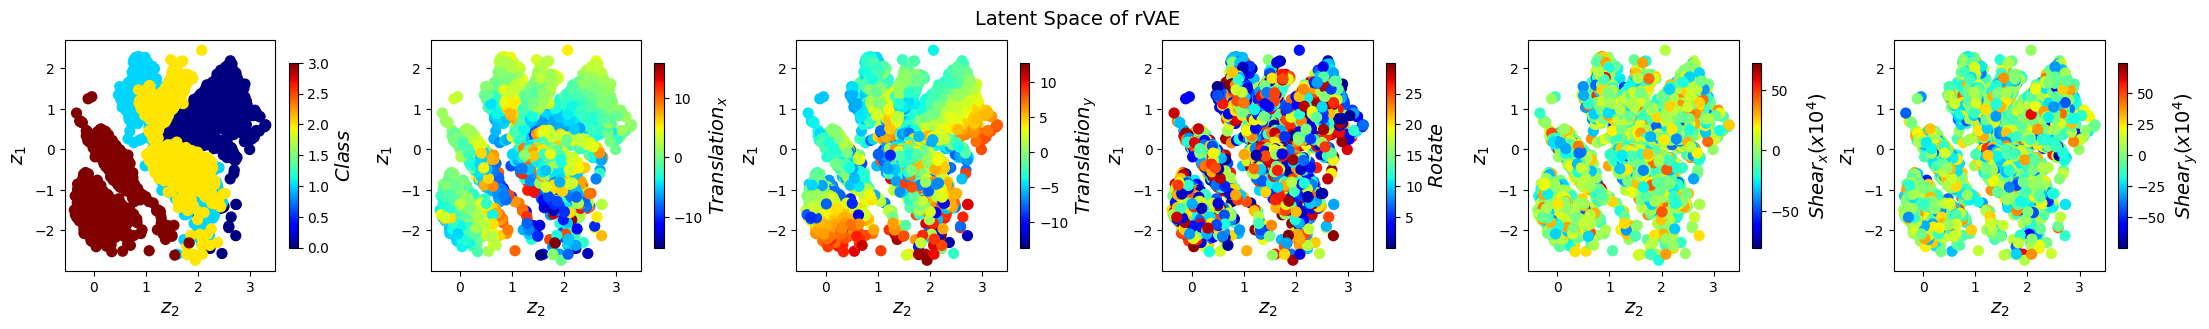

In [ ]:
z_mean, z_sd = vae0.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of rVAE", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)
#ax1.set_xlim(-2, 2)
#ax1.set_ylim(-2, 2)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)
#ax2.set_xlim(-2, 2)
#ax2.set_ylim(-2, 2);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)
#ax3.set_xlim(-2, 2)
#ax3.set_ylim(-2, 2);

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)
# ax4.set_xlim(-2, 2)
# ax4.set_ylim(-2, 2);

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)
#ax2.set_xlim(-2, 2)
#ax2.set_ylim(-2, 2);

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)
#ax3.set_xlim(-2, 2)
#ax3.set_ylim(-2, 2);ontsize=14)
# ax4.set_xlim(-2, 2)
# ax4.set_ylim(-2, 2);


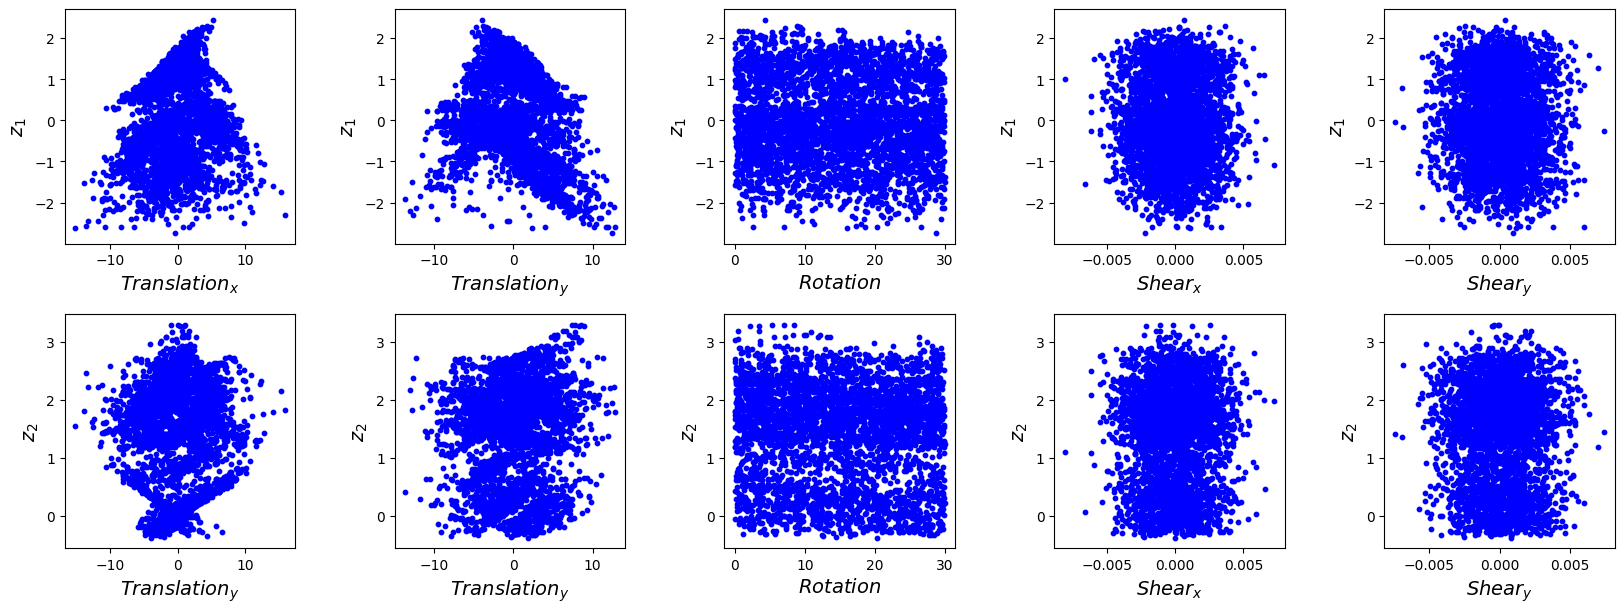

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)
#fig.suptitle("Latent Space of VAE with Condition: Rotate ", fontsize=14)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = 'b', s = 10)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

Text(0, 0.5, '$Rotate Variable$')

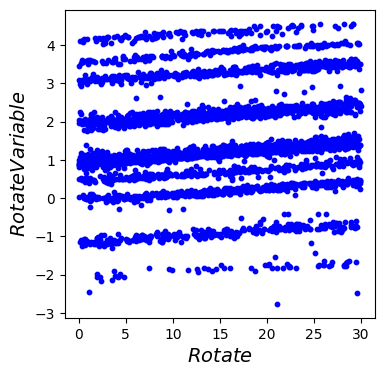

In [ ]:
fig, ax2 = plt.subplots(figsize=(4, 4))
fig.subplots_adjust(wspace = 0.39)
# fig.suptitle("Latent Space of rVAE", fontsize=14)

# im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
# ax1.set_xlabel("$z_2$", fontsize=14)
# ax1.set_ylabel("$z_1$", fontsize=14)
# cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
# cbar1.set_label("$Class$", fontsize=14)
# #ax1.set_xlim(-2, 2)
# #ax1.set_ylim(-2, 2)

im2 = ax2.scatter(rotate_, z_mean[:, 0], c = 'b', s = 10)
ax2.set_xlabel("$Rotate $", fontsize=14)
ax2.set_ylabel("$Rotate Variable$", fontsize=14)
# cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
# cbar2.set_label("$Translation_x$", fontsize=14)
#ax2.set_xlim(-2, 2)
#ax2.set_ylim(-2, 2);

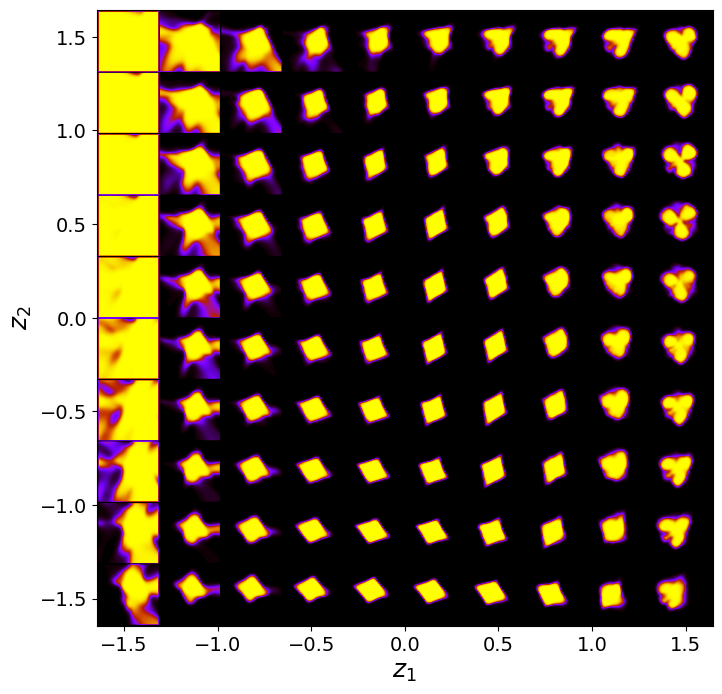

In [ ]:
vae0.manifold2d(10);

Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about shifts as our $c$ vector.

In [ ]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

in_dim = (80, 80)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae1 = pv.models.iVAE(in_dim, latent_dim=2, invariances='t', seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae1)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 2892.7072
Epoch: 2 Training loss: 2130.1446
Epoch: 3 Training loss: 1095.9110
Epoch: 4 Training loss: 941.1695
Epoch: 5 Training loss: 889.5469
Epoch: 6 Training loss: 881.7118
Epoch: 7 Training loss: 884.4776
Epoch: 8 Training loss: 872.4023
Epoch: 9 Training loss: 858.1770
Epoch: 10 Training loss: 900.9092
Epoch: 11 Training loss: 836.9045
Epoch: 12 Training loss: 829.6045
Epoch: 13 Training loss: 835.3469
Epoch: 14 Training loss: 820.5398
Epoch: 15 Training loss: 832.7034
Epoch: 16 Training loss: 810.6988
Epoch: 17 Training loss: 809.2687
Epoch: 18 Training loss: 804.6811
Epoch: 19 Training loss: 798.8017
Epoch: 20 Training loss: 793.2086
Epoch: 21 Training loss: 786.1244
Epoch: 22 Training loss: 781.4439
Epoch: 23 Training loss: 780.4825
Epoch: 24 Training loss: 727.8316
Epoch: 25 Training loss: 696.1362
Epoch: 26 Training loss: 659.6701
Epoch: 27 Training loss: 623.9849
Epoch: 28 Training loss: 614.8313
Epoch: 29 Training loss: 604.8963
Epoch: 30 Training l

Encode the training data into the latent space:

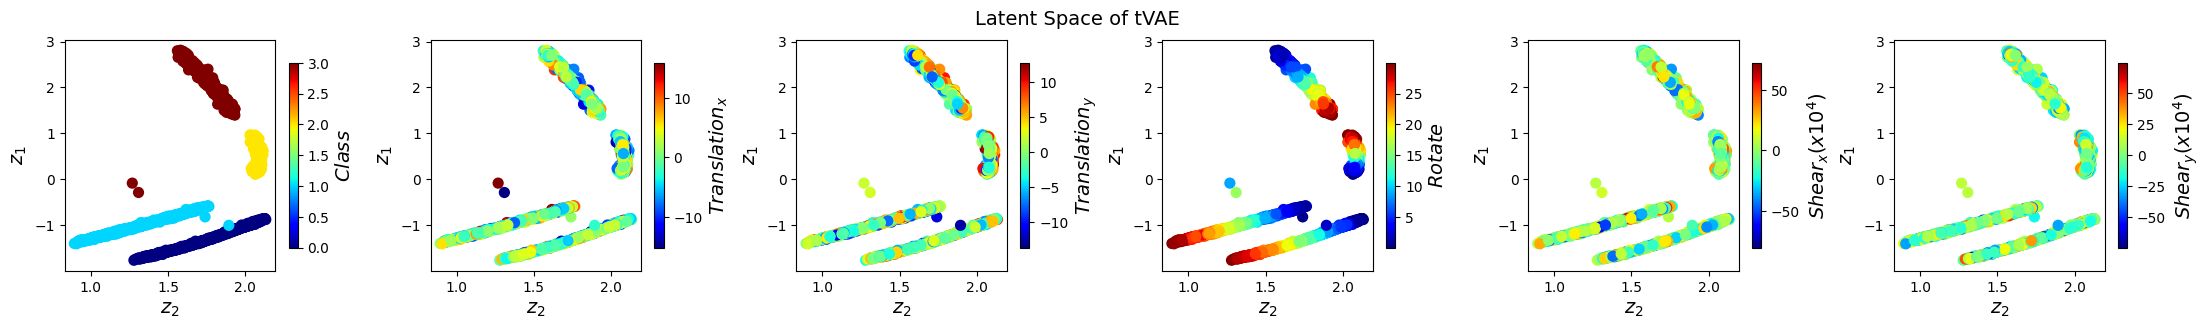

In [ ]:
z_mean, z_sd = vae1.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of tVAE", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)
#ax1.set_xlim(-2, 2)
#ax1.set_ylim(-2, 2)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)
#ax2.set_xlim(-2, 2)
#ax2.set_ylim(-2, 2);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)
#ax3.set_xlim(-2, 2)
#ax3.set_ylim(-2, 2);

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)
# ax4.set_xlim(-2, 2)
# ax4.set_ylim(-2, 2);

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)
#ax2.set_xlim(-2, 2)
#ax2.set_ylim(-2, 2);

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)
#ax3.set_xlim(-2, 2)
#ax3.set_ylim(-2, 2);ontsize=14)
# ax4.set_xlim(-2, 2)
# ax4.set_ylim(-2, 2);

- Plot the learned latent manifolds conditioned on the parameter.

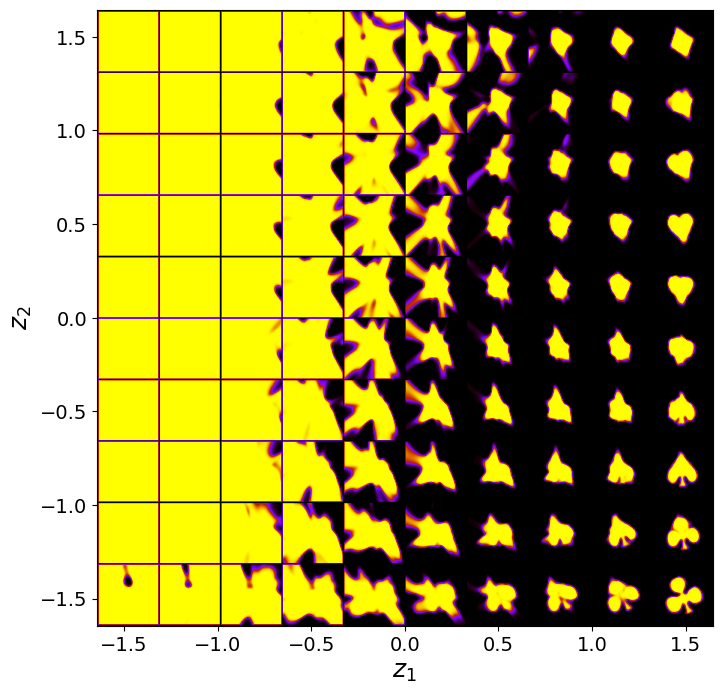

In [ ]:
vae1.manifold2d(10);

Plot the latent variables vs. the ground truth:

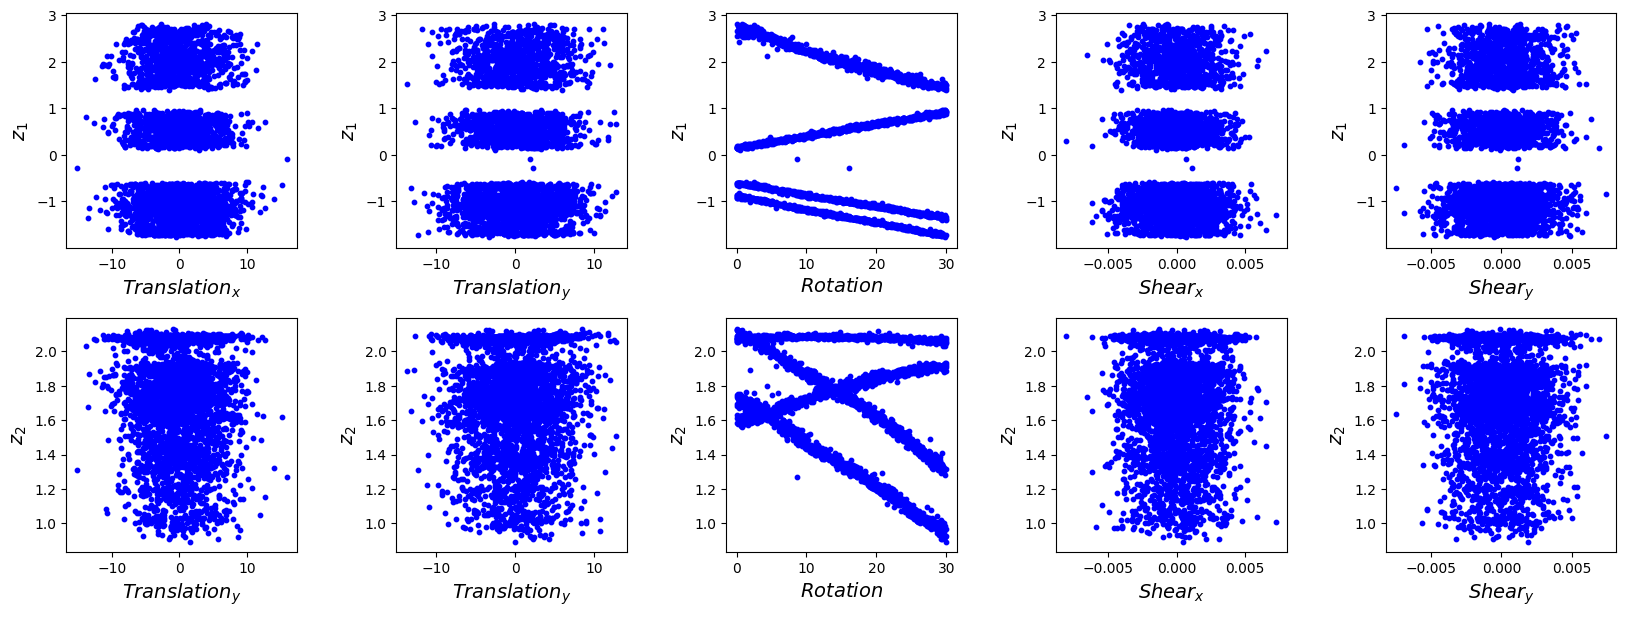

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)
#fig.suptitle("Latent Space of VAE with Condition: Rotate ", fontsize=14)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = 'b', s = 10)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = 'b', s = 10);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = 'b', s = 10);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

Text(0, 0.5, '$Shift Variable$')

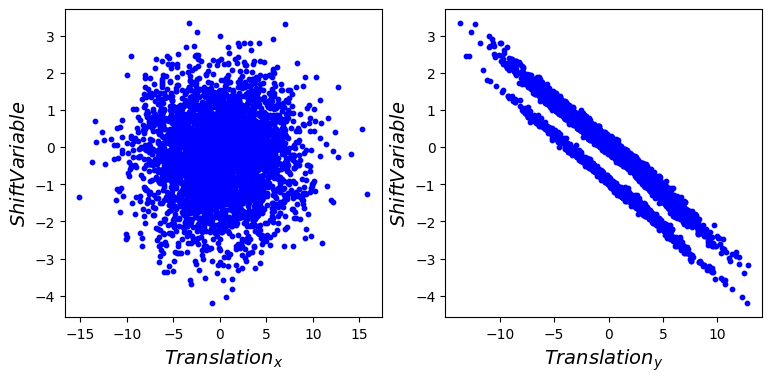

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 4))
fig.subplots_adjust(wspace = 0.2)
# fig.suptitle("Latent Space of rVAE", fontsize=14)

im1 = ax1.scatter(translation_x_, z_mean[:,0], c = 'b', s = 10) 
ax1.set_xlabel("$Translation_x$", fontsize=14)
ax1.set_ylabel("$Shift Variable$", fontsize=14)
# cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
# cbar1.set_label("$Class$", fontsize=14)
#ax1.set_xlim(-2, 2)
#ax1.set_ylim(-2, 2)

im2 = ax2.scatter(translation_y_, z_mean[:, 0], c = 'b', s = 10)
ax2.set_xlabel("$Translation_y$", fontsize=14)
ax2.set_ylabel("$Shift Variable$", fontsize=14)
# cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
# cbar2.set_label("$Translation_x$", fontsize=14)
#ax2.set_xlim(-2, 2)
#ax2.set_ylim(-2, 2);